# Winter comparison

This notebook calculates mean monthly values for each data variable, and then compares mean values between winter 2018-19 and winter 2019-20. This allows us to visualize any differences between the two winter seasons. 
 
 
**Input**:
 - xarray dataset from the jupyter book's google bucket
 
 
 **Output**: 
  - Line plots displayed in notebook

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !pip install netcdf4
    !pip install xarray==0.16.0 

## Import notebook dependencies

In [2]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
 
#increase resolution for notebook outputs
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

## Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

In [3]:
!gsutil -m cp gs://icesat2-book-data/icesat2-book-winter-data.nc ./
dataset = xr.open_dataset('icesat2-book-winter-data.nc')

Copying gs://icesat2-book-data/icesat2-book-winter-data.nc...



Operation completed over 1 objects/163.4 MiB.                                    


## Restrict dataset to region of interest

In [4]:
#function from regional_analysis notebook
def restrictRegionally(dataset, regionKeyList): 
    """Restrict dataset to input regions.
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
        regionKeyList (list): list of region keys to restrict data to 
        
    Returns: 
        regionalDataset (xr Dataset): dataset with restricted data to input regions
    """
    
    def checkKeys(regionKeyList, regionTbl): 
        """Check that regionKeyList was defined correctly

        Raises: 
            ValueError if regionKeyList was not defined correctly 
            warning if all data was removed from the dataset
        """
        if type(regionKeyList) != list: #raise a ValueError if regionKeyList is not a list 
            raise ValueError('regionKeyList needs to be a list. \nFor example, if you want to restrict data to the Beaufort Sea, define regionKeyList = [13]')

        for key in regionKeyList: 
            if key not in list(regionTbl['key']): 
                raise ValueError('Region key ' + str(key) + ' does not exist in region mask. \n Redefine regionKeyList with key numbers from table')

        if len(regionKeyList) == 0: 
            warnings.warn('You removed all the data from the dataset. Are you sure you wanted to do this? \n If not, make sure the list regionKeyList is not empty and try again. \n If you intended to keep data from all regions, set regionKeyList = list(tbl[\"key\"])')
 
    #create a table of keys and labels
    regionMask = dataset.region_mask.attrs
    regionTbl = pd.DataFrame({'key': regionMask['keys'], 'label': regionMask['labels']})
    
    #call function to check if regionKeyList was defined correctly
    checkKeys(regionKeyList, regionTbl)
    
    #keys to remove (all keys that are note listed in regionKeyList)
    keysToRemove = [key for key in list(regionTbl['key']) if key not in regionKeyList]
    
    #filter elements from the ice thickness DataArray where the region is the desired region
    regionalDataset = dataset.copy()
    for var in dataset.data_vars: 
        if var != 'seaice_conc_monthly_cdr':
            regionalVar = regionalDataset[var]
            for key in keysToRemove: 
                regionalVar = regionalVar.where(regionalVar['region_mask'] != key)
            regionalDataset[var] = regionalVar
    
    #find name of labels 
    labels = [regionTbl[regionTbl['key'] == key]['label'].item() for key in regionKeyList]
    
    #add new attributes describing changes made to the dataset
    if len(labels) < len(regionTbl['key']): 
        if set(regionKeyList) == set([10,11,12,13,15]): #convert to sets so unordered lists are compared
            regionalDataset.attrs['regions with data'] = 'Inner Arctic'
        else:    
            regionalDataset.attrs['regions with data'] = ('%s' % ', '.join(map(str, labels)))
        print('Regions selected: ' + regionalDataset.attrs['regions with data'])
    else: 
        regionalDataset.attrs['regions with data'] = 'All'
        print('Regions selected: All \nNo regions will be removed')
    
    return regionalDataset

In [5]:
#define a list of keys corresponding to the region of interest
regionKeyList = [10,11,12,13,15] #Inner Arctic

#restrict data to that region
dataset = restrictRegionally(dataset, regionKeyList)

Regions selected: Inner Arctic


## Calculate mean monthly values for each data variable
Define a function that calculates and plots mean monthly values for each data variable.

In [6]:
def compareWinters(dataset, dataVar):
    """ Plots mean monthly ice thickness for two winter seasons. 
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook

    Returns: 
        Figure displayed in notebook 
     
    Restrictions: 
        dataset input needs to contain the following coordinates: mean_ice_thickness_unc, mean_ice_thickness, mean_MYI_thickness, mean_FYI_thickness 
    """
    
    #calculate monthly means 
    means = dataset[dataVar].mean(dim = ['x','y'], skipna = True)
        
    #initialize figure & axes 
    fig = plt.figure()
    ax = plt.axes([0,0,1,1])
    title = fig.suptitle('Winter comparison: ' + dataset[dataVar].attrs['long_name'] + ' (' + dataset[dataVar].attrs['units'] + ')', y = 1.15, fontsize = 'x-large', wrap = True, horizontalalignment = 'center')
        #add title describing regions with data 
    if 'regions with data' in list(dataset.attrs.keys()): 
        regionsText = dataset.attrs['regions with data']
        regionsTitle = ax.text(x = 0.5, y = 1.04, s = 'Region/s: ' + regionsText, size = 12, transform=ax.transAxes, fontsize = 'large', horizontalalignment = 'center')
    gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) #add gridlines 
    
    #get list of months for plotting x axis 
    winterMonths = ['Nov','Dec','Jan','Feb','Mar','Apr']

    #plot data for winter 1
    meansWinter1 = means.sel(time = slice('Nov 2018','Apr 2019'))
    ax.plot(winterMonths, meansWinter1.values, color = 'royalblue', linestyle = '--', marker = 'o', label = 'Winter ' + str(2018)[2:4] + '-' + str(2019)[2:4])
    
    #plot data for winter 2
    meansWinter2 = means.sel(time = slice('Nov 2019','Apr 2020'))
    ax.plot(winterMonths, meansWinter2.values, color = 'darkgoldenrod', linestyle = '-', marker = 's', label = 'Winter ' + str(2019)[2:4] + '-' + str(2020)[2:4])

    #add legend & labels
    ax.legend(loc = 'best', fontsize = 10)
    ax.set_ylabel(dataset[dataVar].attrs['long_name'])
    ax.set_xlabel('Month')
 
    plt.show()

## Call function to plot data 
Call the function on different data variables in the dataset to visualize how the mean values differed between winter seasons.

### ICESat-2 ice thickness

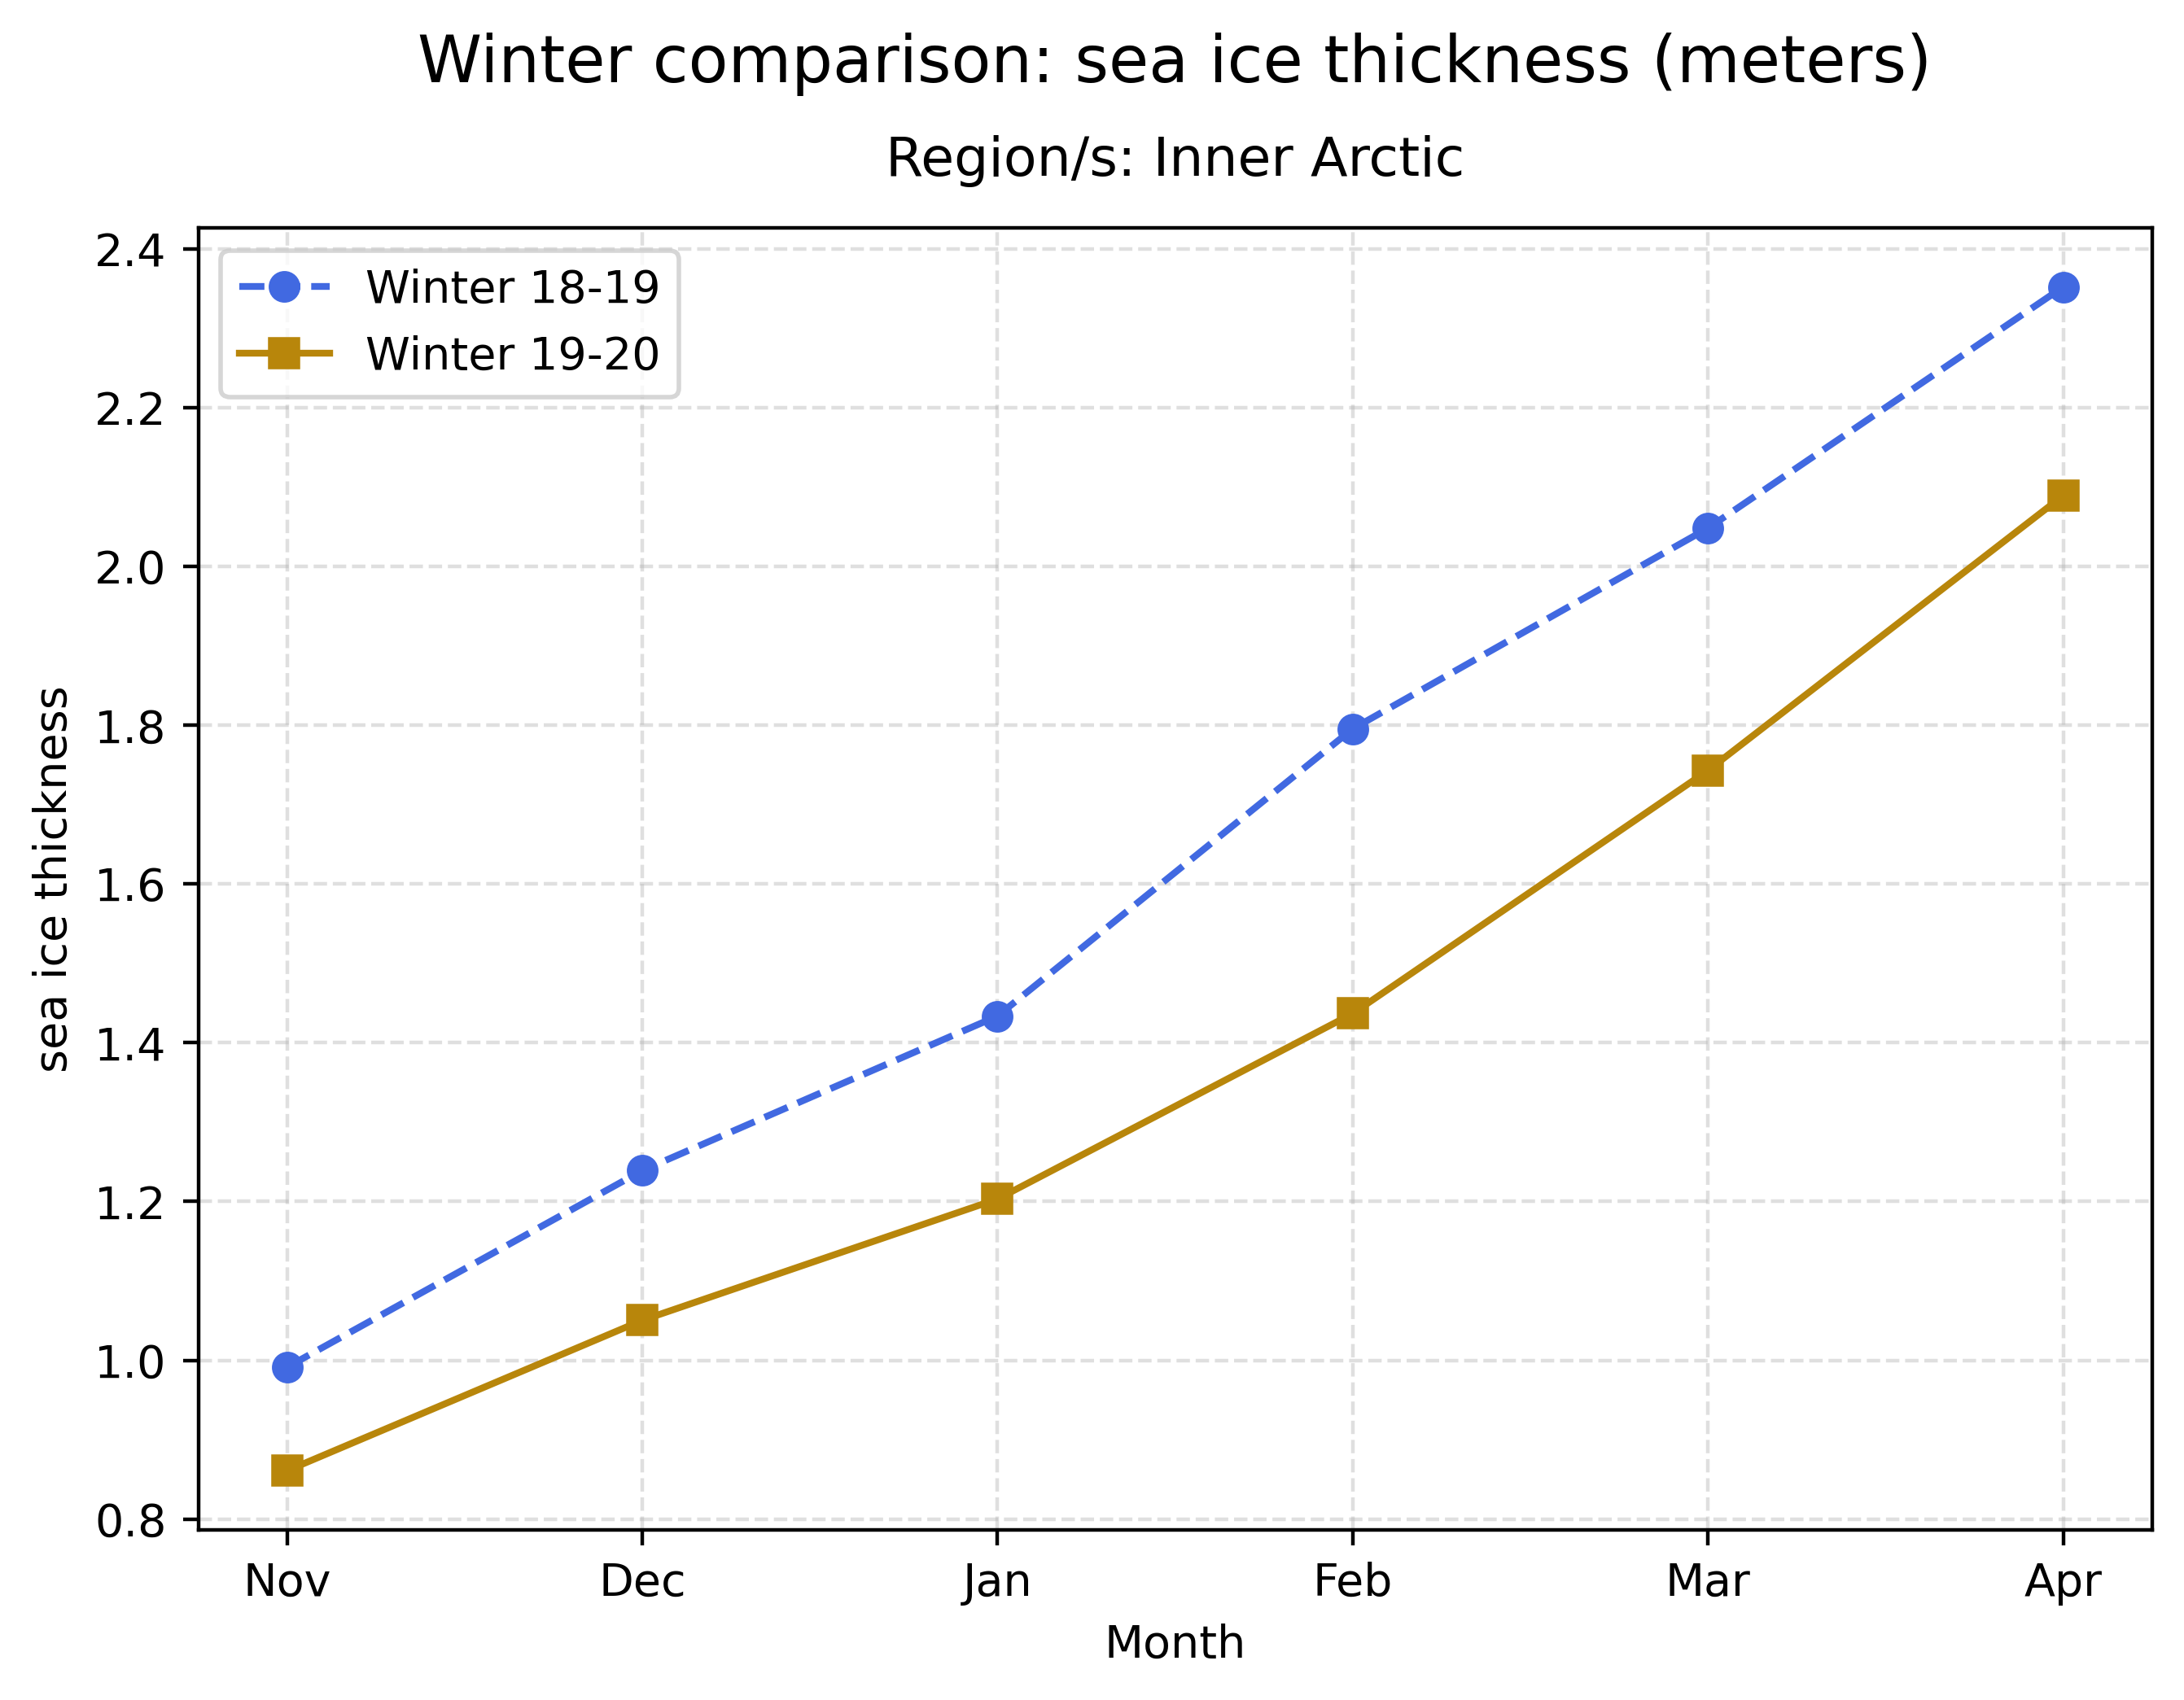

In [7]:
compareWinters(dataset, 'ice_thickness_filled')

### PIOMAS ice thickness

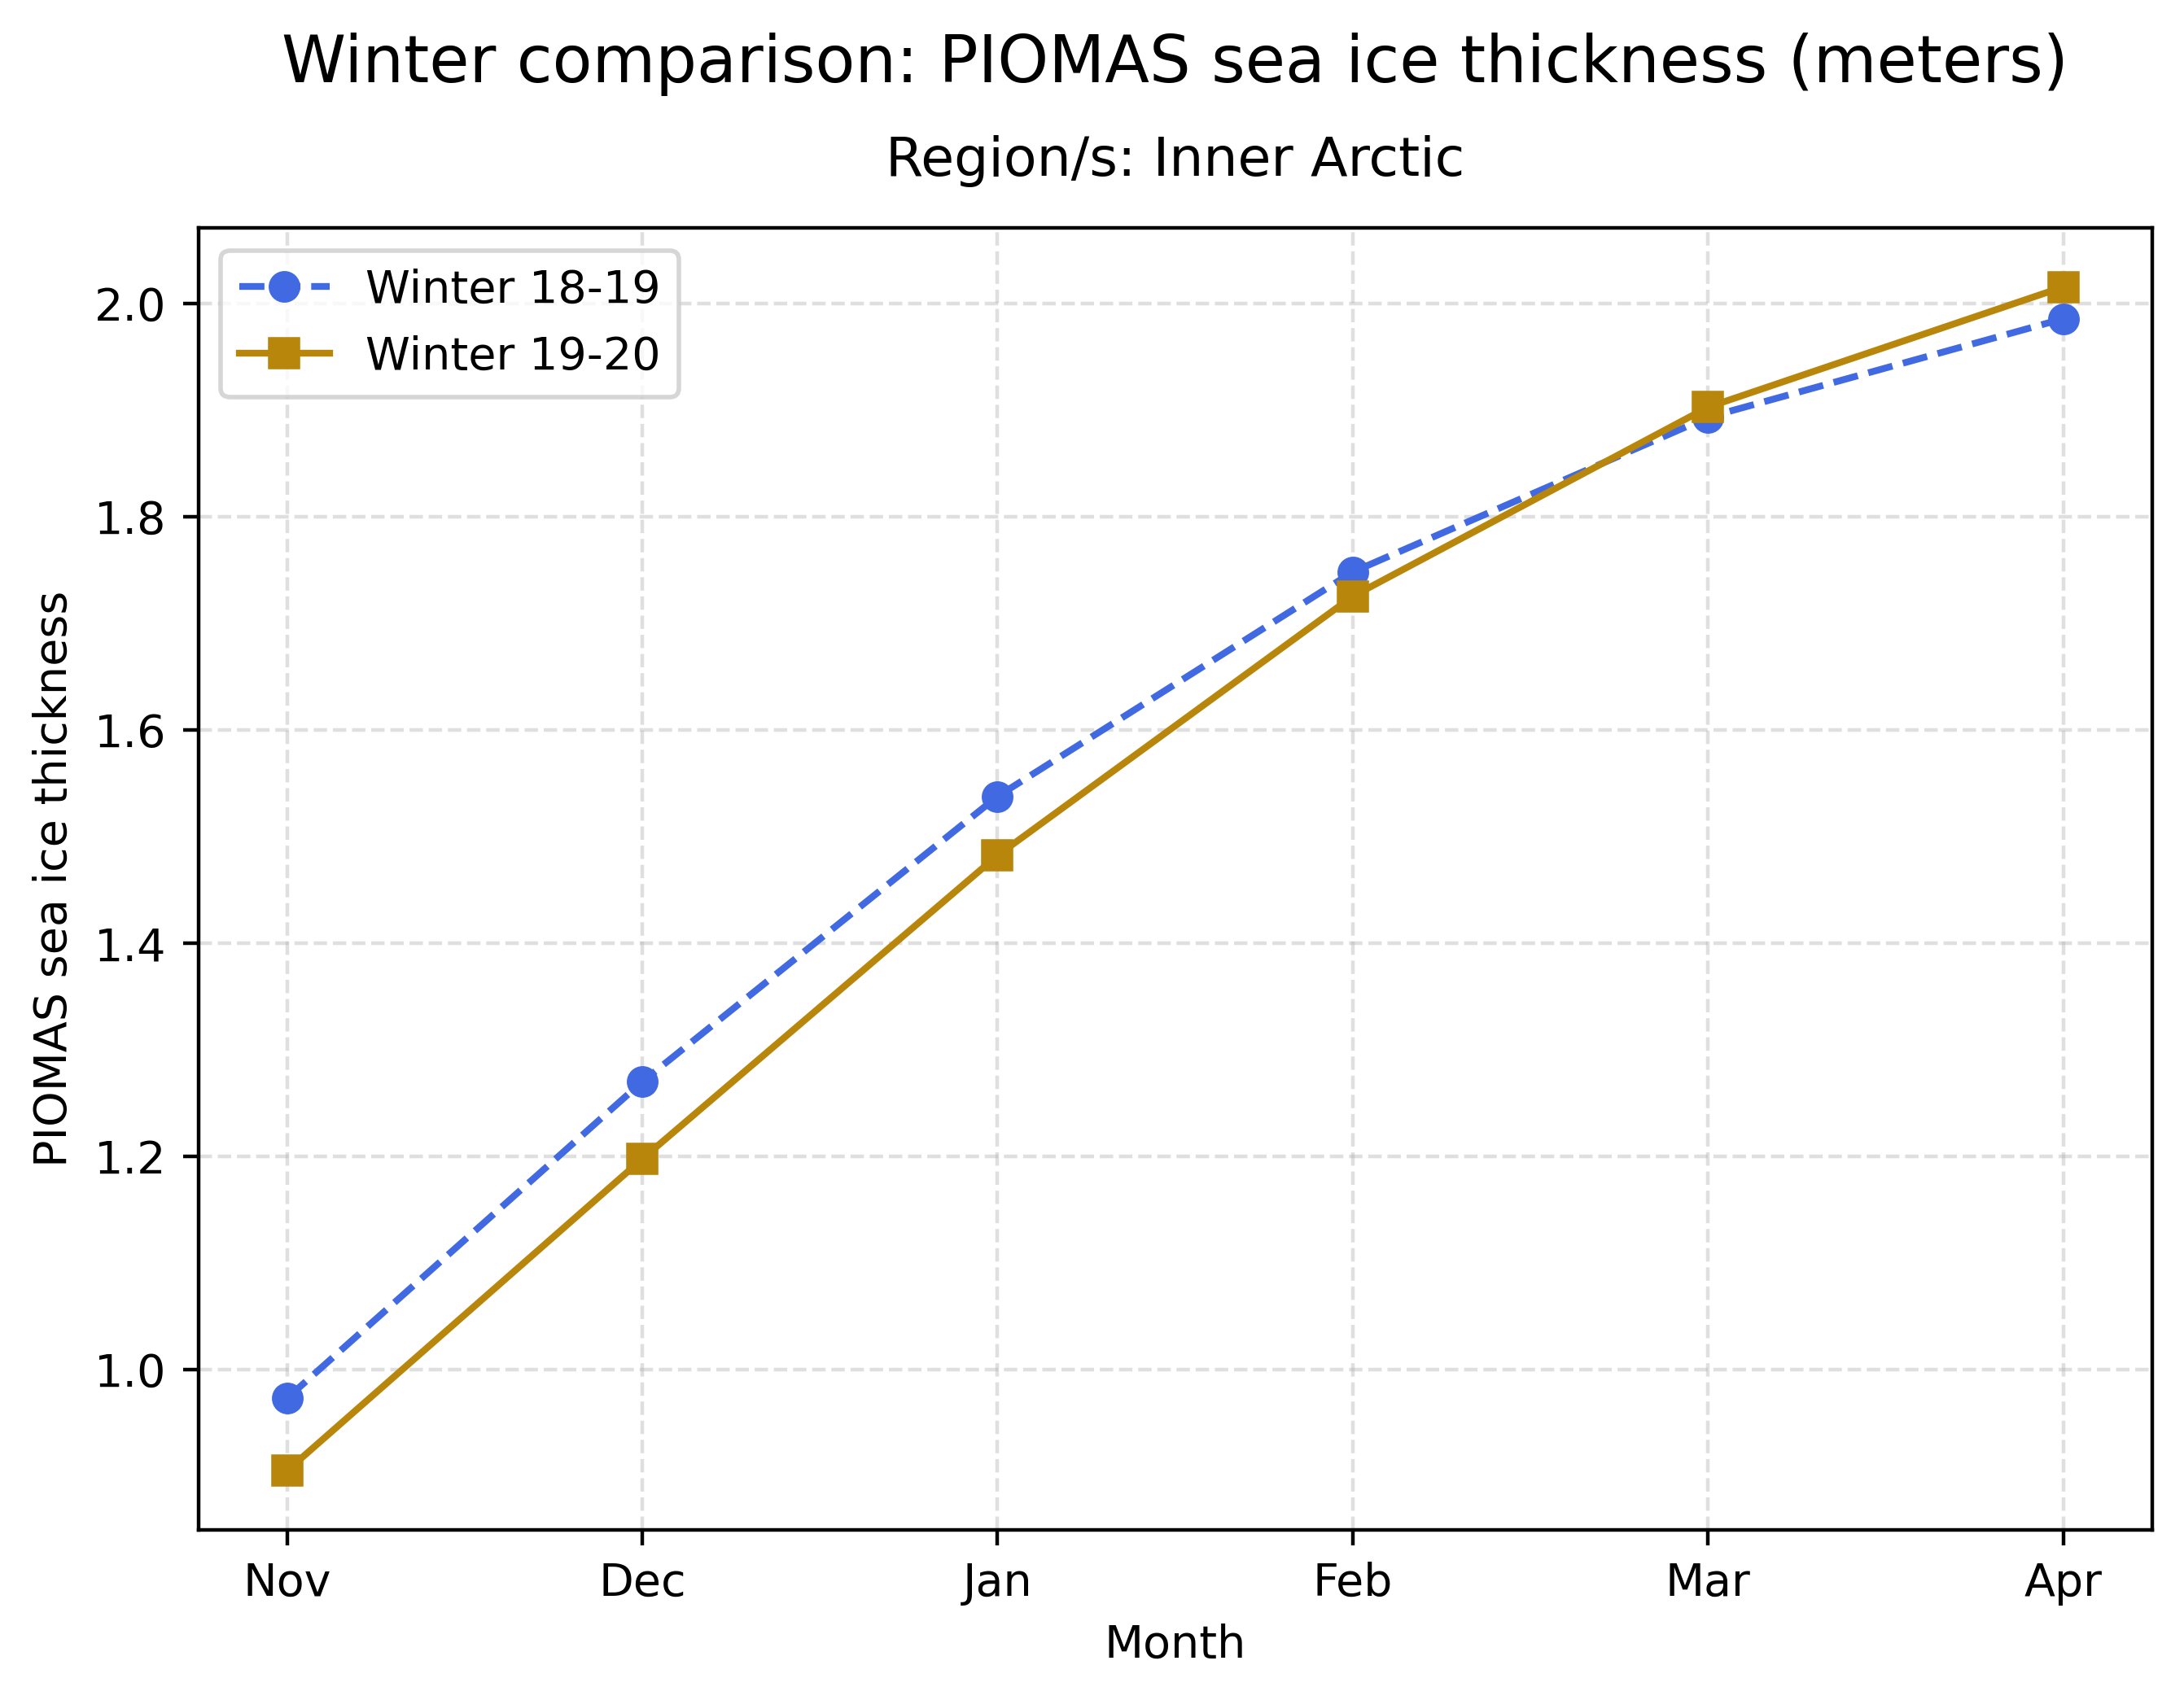

In [8]:
compareWinters(dataset, 'PIOMAS_ice_thickness')

### OSI-SAF ice type
Ice type is either multi-year ice (set to 1) or first-year ice (set to 0). 

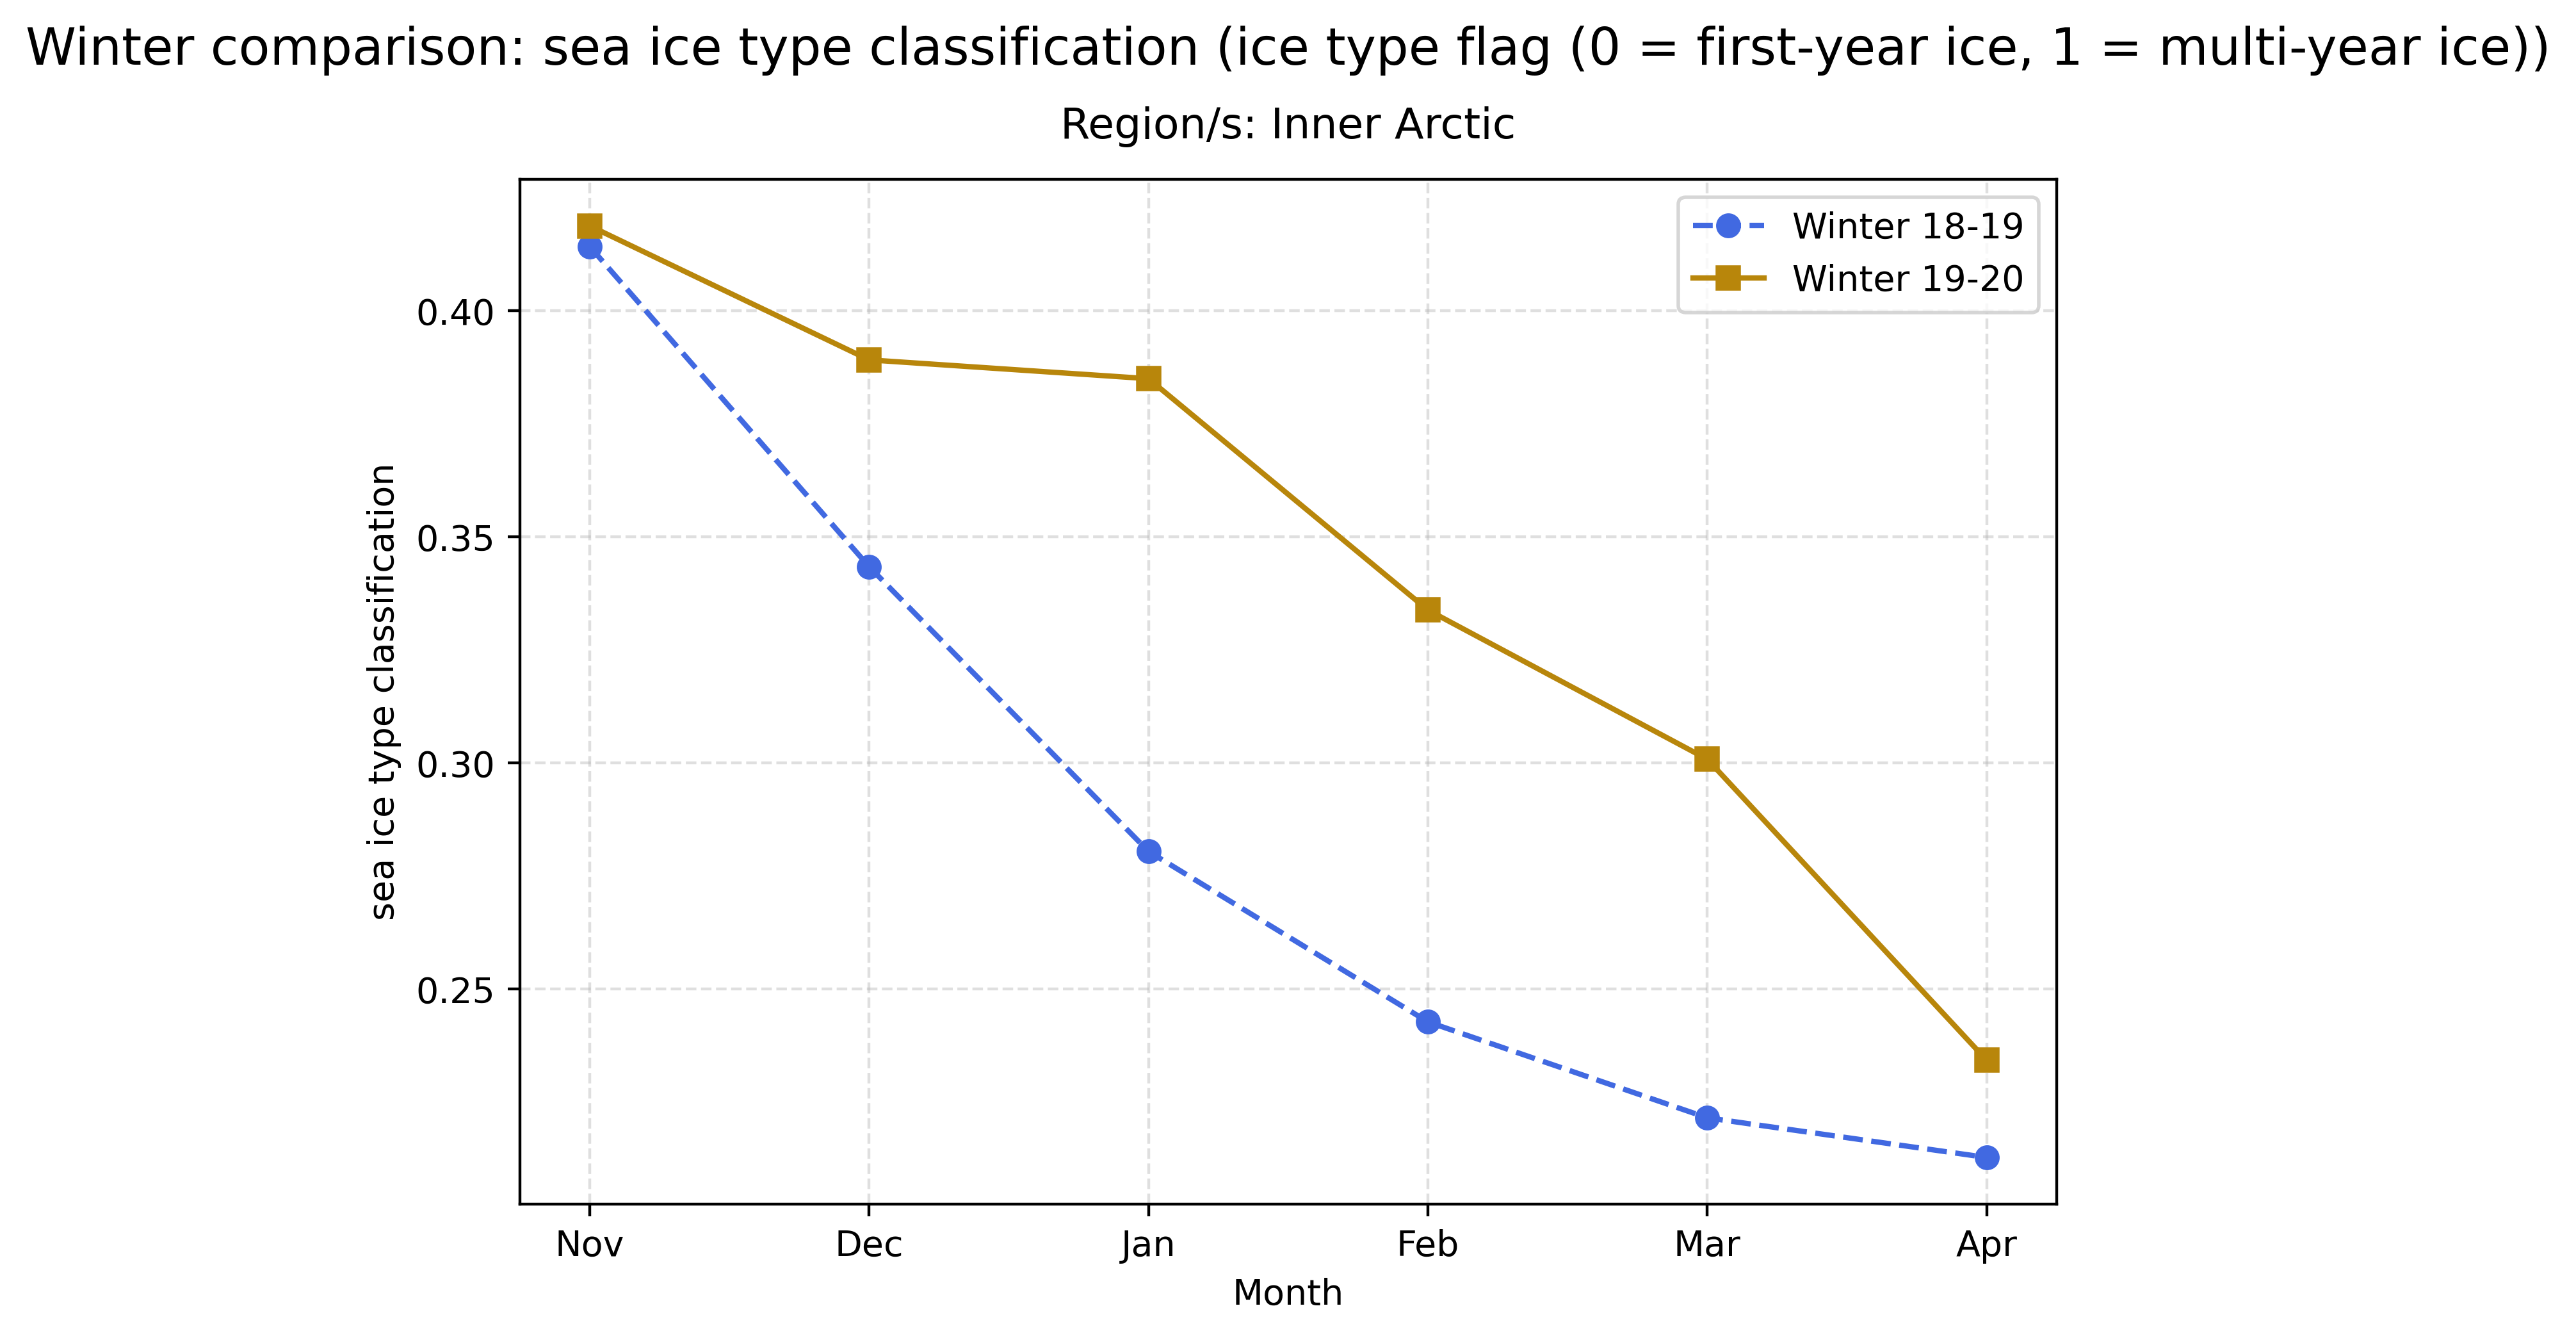

In [9]:
compareWinters(dataset, 'ice_type_filled')

### ERA5 2-meter temperature 

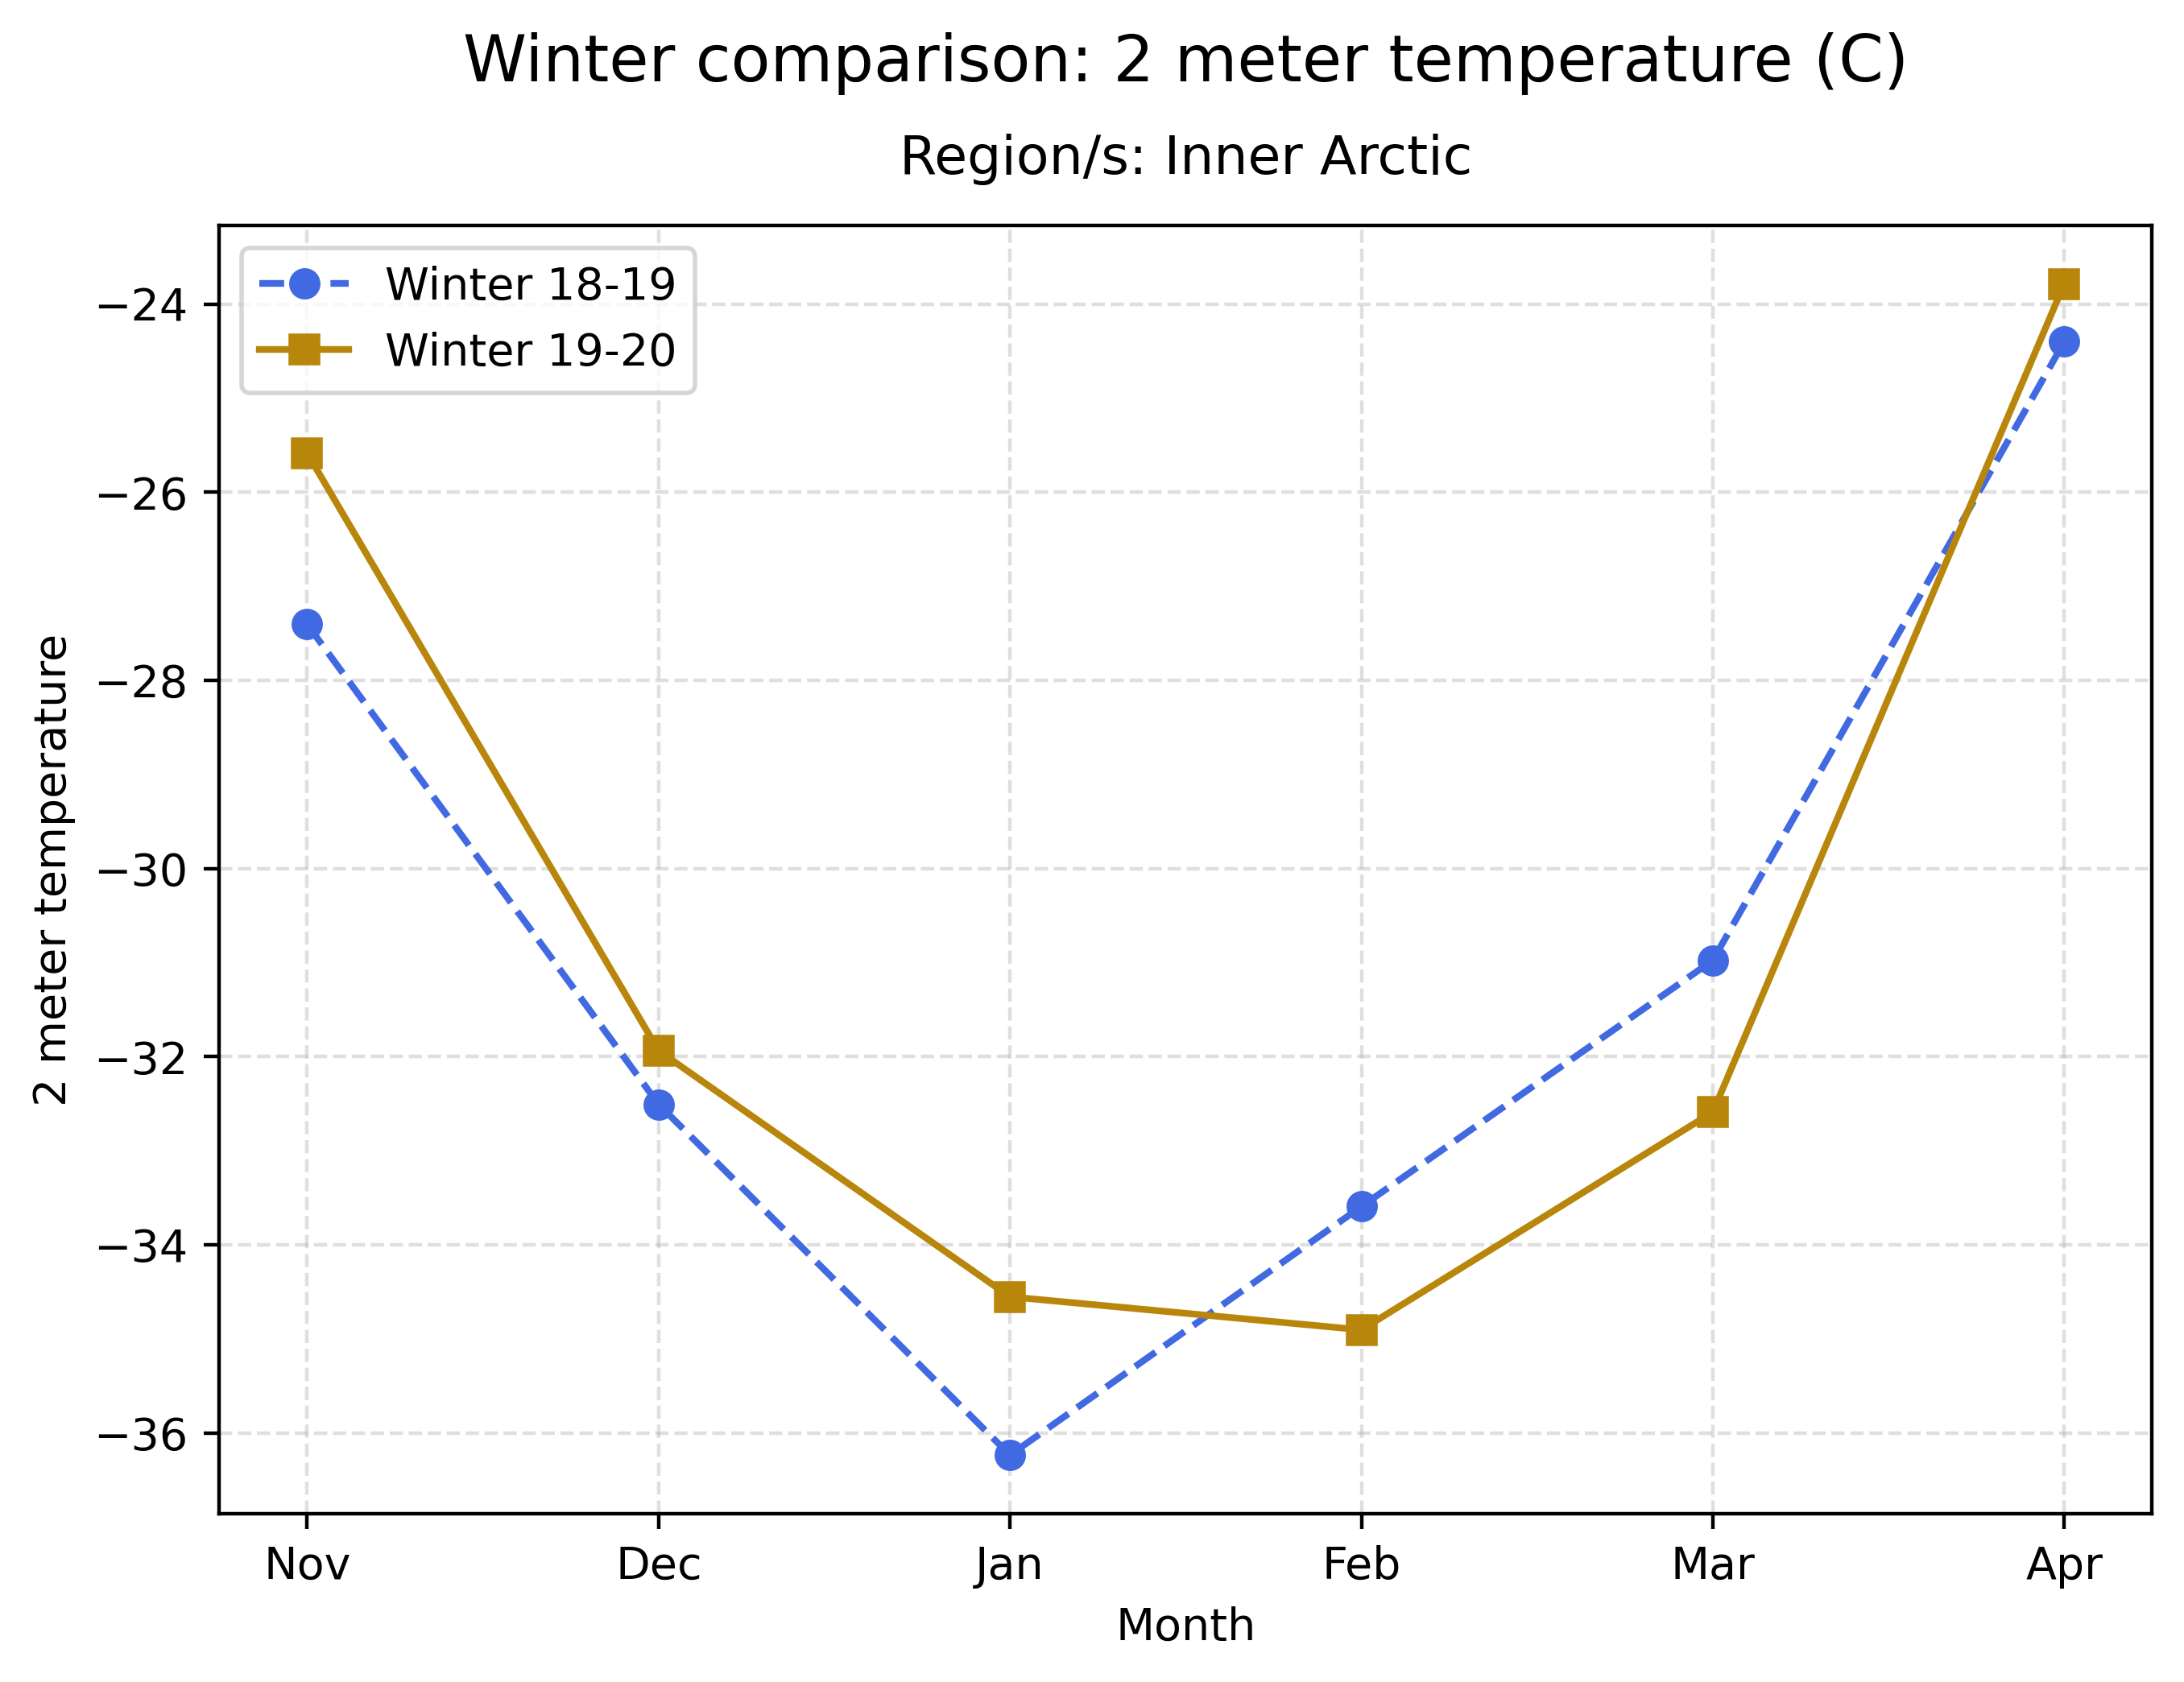

In [10]:
compareWinters(dataset, 't2m')

### ERA5 mean surface downward long-wave radiation flux

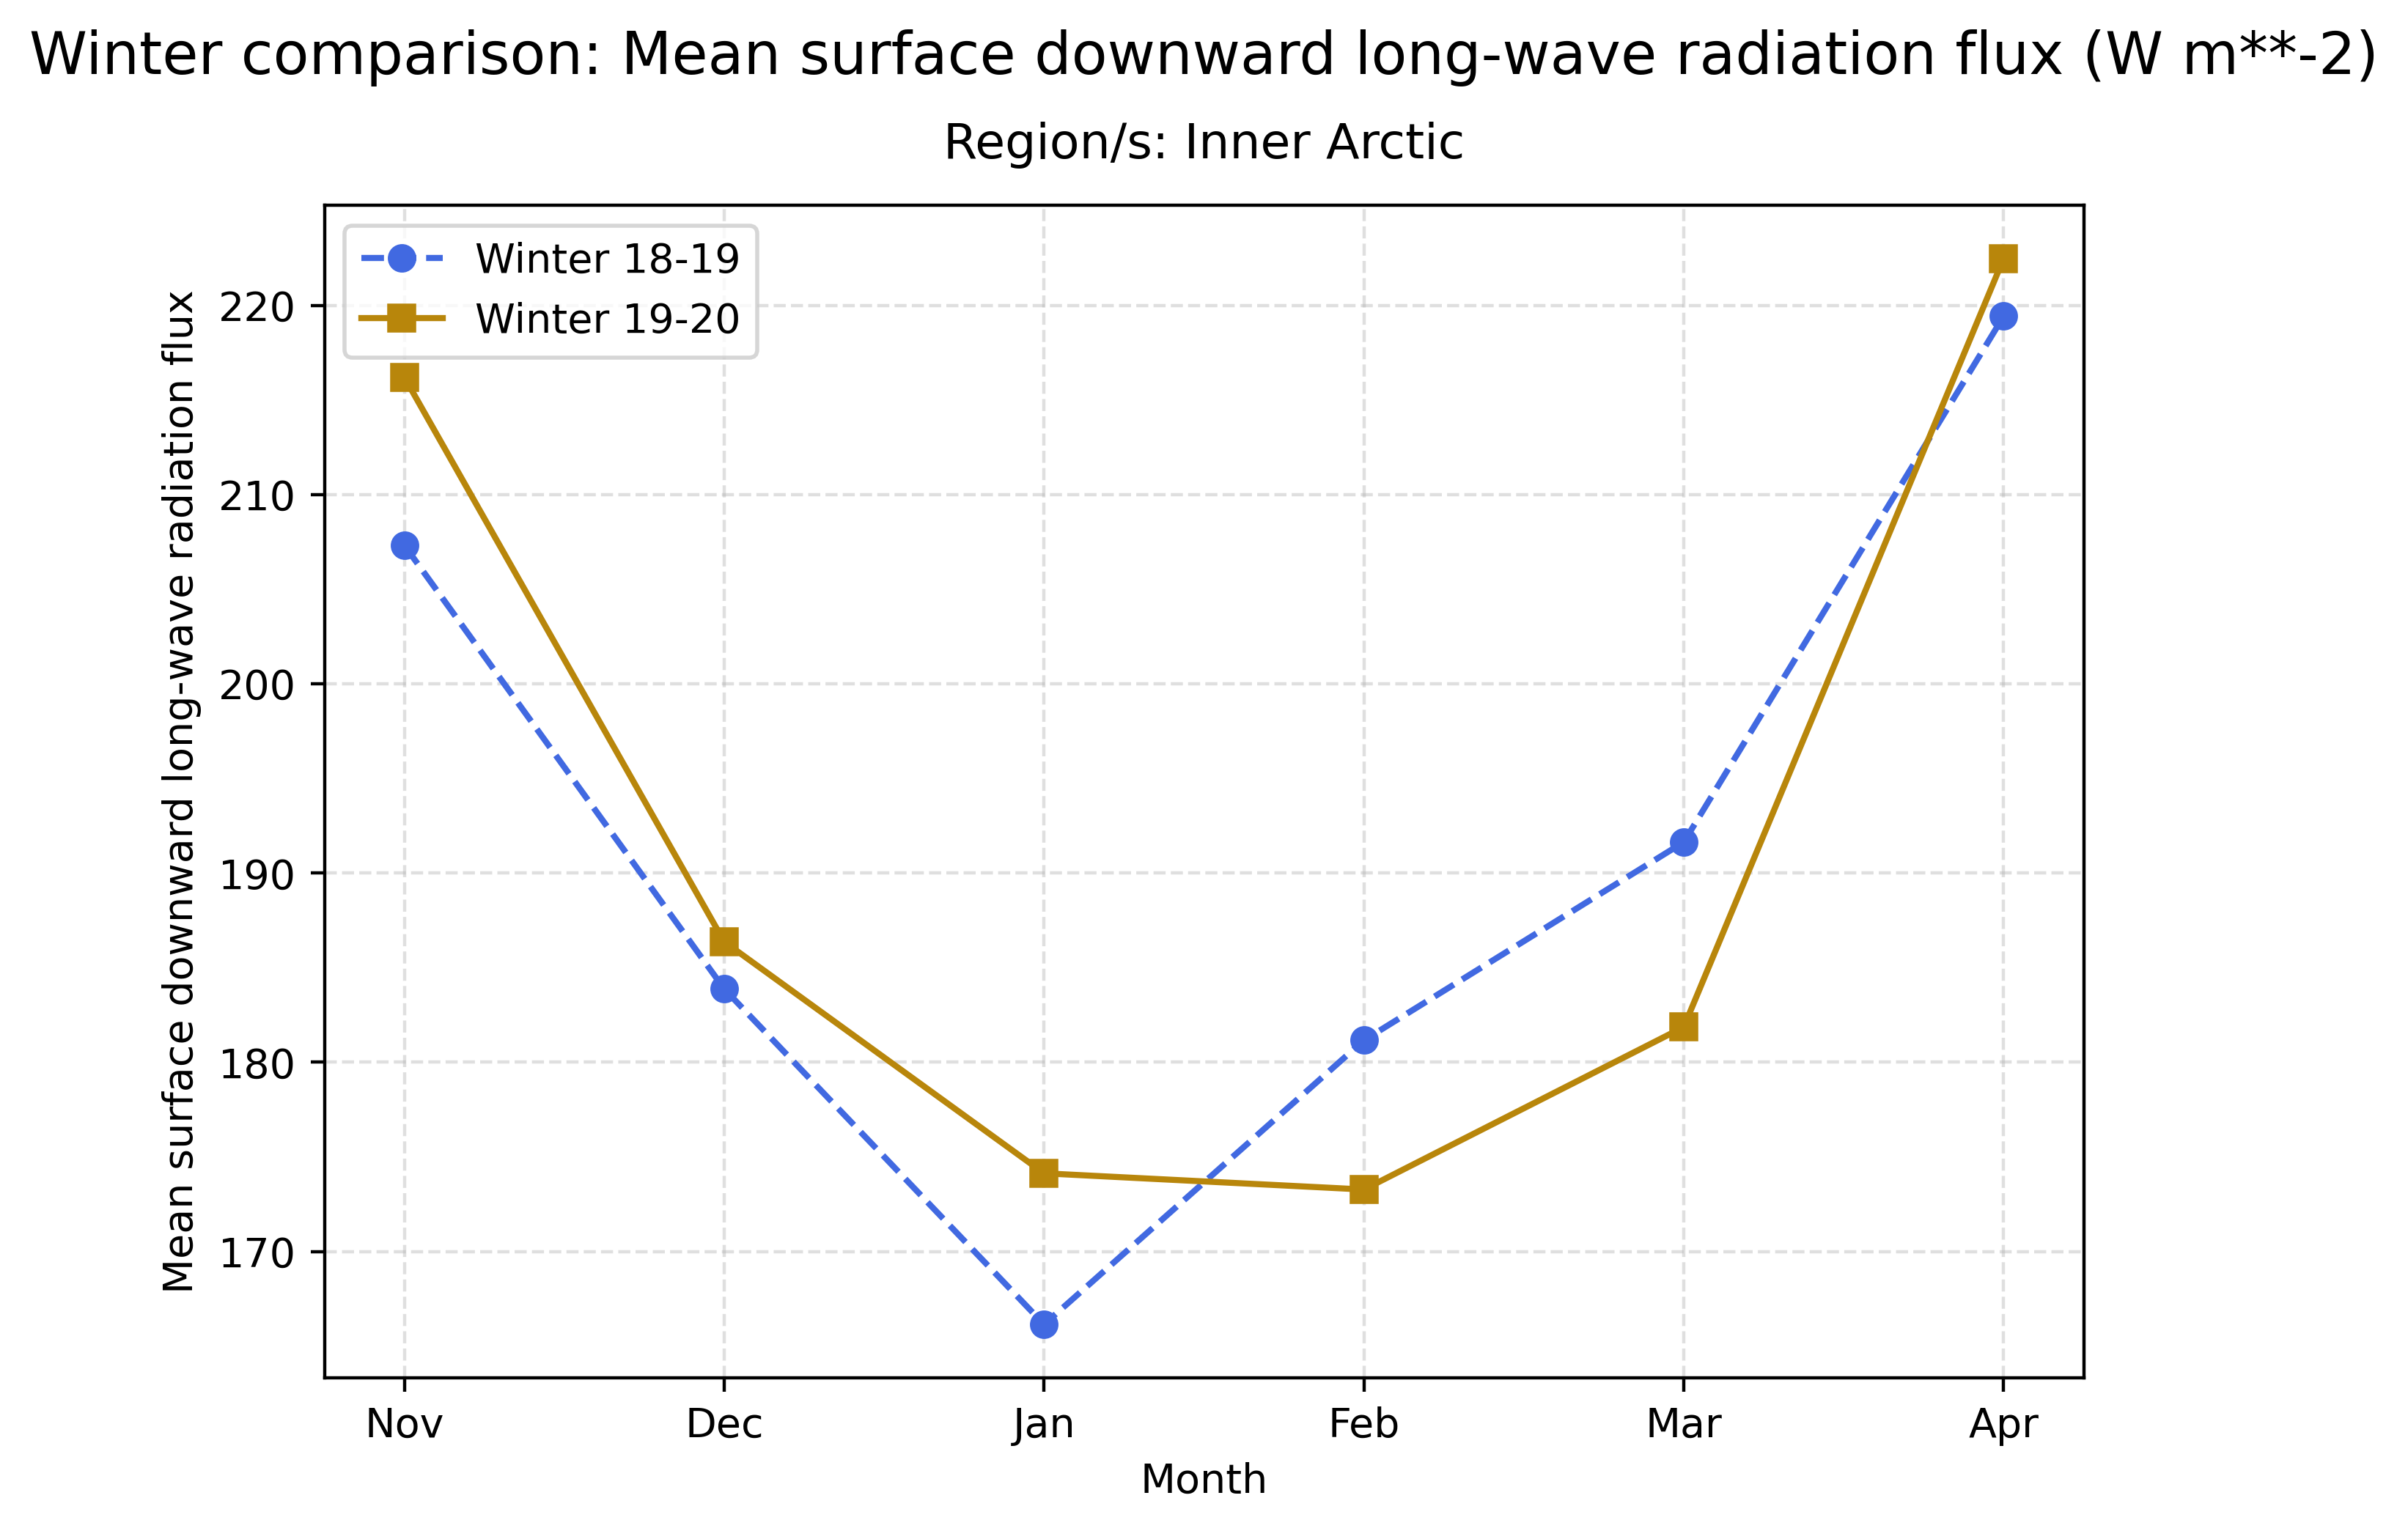

In [11]:
compareWinters(dataset, 'msdwlwrf')